In [1]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# Custom Dataset
class DetectDataset(Dataset):
    def __init__(self, labels_dir, img_dir, transform=None, target_transform=None):
        self.labels_dir = labels_dir
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        
    def __len__(self):
        return len(self.img_files)
        
    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)
        
        label_path = os.path.join(self.labels_dir, img_name.replace('.jpg', '.txt'))
        label = self._load_label(label_path)
        
        # Apply transformations to image
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label
    
    # Helper function to get label from images
    def _load_label(self, label_path):
        # parse the label path and read files
        with open(label_path, 'r') as file:
            boxes = []
            for line in file.readlines():
                # Grab label variables from file
                class_id, x_center, y_center, width, height = map(float, line.strip().split()) # returns list of float from split line
                boxes.append([class_id, x_center, y_center, width, height])
        # Select the first box to satisfy torch.stack operations
        first_bbox = boxes[0]
        return torch.tensor(first_bbox)

In [4]:
# Variable Length Data: Each image can have a different number of bounding boxes. 
# The default collate_fn tries to stack everything into tensors, which fails if they have different shapes.

# Stack images into tensors but not targets to avoid this conflict
def collate_fn(batch):
    images = []
    targets = []
    for sample in batch:
        images.append(sample[0])
        targets.append(sample[1])
    images = torch.stack(images, dim=0)
    return images, targets

In [5]:
# class IDs
classes = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']

In [6]:
train_labels_dir = "../data/VehiclesDetectionDataset/train/labels/"
train_img_dir = "../data/VehiclesDetectionDataset/train/images/"
test_labels_dir = "../data/VehiclesDetectionDataset/test/labels/"
test_img_dir = "../data/VehiclesDetectionDataset/test/images/"

In [7]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# load images dataset
trainset = DetectDataset(train_labels_dir, train_img_dir, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, collate_fn=collate_fn)

In [8]:
# Calculate mean and std of image dataset
sum_ = torch.zeros(3)
sum_squared = torch.zeros(3)
num_images = 0

for images, _ in trainloader:
    sum_ += images.sum(dim=[0, 2, 3])
    sum_squared += (images ** 2).sum(dim=[0, 2, 3])
    num_images += images.size(0)

mean = sum_ / (num_images * images.size(2) * images.size(3))
std = (sum_squared / (num_images * images.size(2) * images.size(3)) - mean ** 2).sqrt()

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.4525, 0.4424, 0.4260])
Std: tensor([0.2787, 0.2777, 0.2892])


In [9]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [10]:
norm_trainset = DetectDataset(train_labels_dir, train_img_dir, transform=transform)
norm_trainloader = DataLoader(trainset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [11]:
testset = DetectDataset(test_labels_dir, test_img_dir, transform=transform)
testloader = DataLoader(testset, batch_size=8, shuffle=True)

In [12]:
train_features, train_labels = next(iter(norm_trainloader))

In [13]:
train_labels

[tensor([2.0000, 0.8462, 0.7680, 0.1671, 0.0805]),
 tensor([0.0000, 0.2488, 0.5300, 0.3401, 0.3185]),
 tensor([4.0000, 0.6358, 0.6274, 0.5649, 0.4519]),
 tensor([2.0000, 0.5998, 0.6478, 0.7356, 0.6214])]

In [14]:
# print(f"Feature shape: {train_features.shape}")
# print(f"Label shape: {torch.tensor(train_labels).shape}")

In [15]:
train_features

tensor([[[[0.0235, 0.0235, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
          [0.0235, 0.0196, 0.0157,  ..., 0.0196, 0.0196, 0.0196],
          [0.0196, 0.0196, 0.0157,  ..., 0.0235, 0.0235, 0.0275],
          ...,
          [0.2000, 0.1922, 0.1922,  ..., 0.1725, 0.1725, 0.1725],
          [0.2000, 0.1843, 0.1882,  ..., 0.1608, 0.1569, 0.1529],
          [0.1961, 0.1804, 0.1843,  ..., 0.1451, 0.1412, 0.1412]],

         [[0.0275, 0.0275, 0.0196,  ..., 0.0196, 0.0196, 0.0196],
          [0.0275, 0.0235, 0.0196,  ..., 0.0235, 0.0235, 0.0235],
          [0.0235, 0.0235, 0.0196,  ..., 0.0275, 0.0275, 0.0314],
          ...,
          [0.1804, 0.1725, 0.1725,  ..., 0.1804, 0.1804, 0.1804],
          [0.1725, 0.1569, 0.1608,  ..., 0.1686, 0.1647, 0.1608],
          [0.1647, 0.1490, 0.1529,  ..., 0.1529, 0.1490, 0.1490]],

         [[0.0353, 0.0353, 0.0275,  ..., 0.0275, 0.0275, 0.0275],
          [0.0353, 0.0314, 0.0275,  ..., 0.0314, 0.0314, 0.0314],
          [0.0314, 0.0314, 0.0275,  ..., 0

In [16]:
train_labels[0]

tensor([2.0000, 0.8462, 0.7680, 0.1671, 0.0805])

Class ID: 2.0
Box Coordinates: tensor([2.0000, 0.8462, 0.7680, 0.1671, 0.0805])
Box Coordinates: tensor([0.0000, 0.2488, 0.5300, 0.3401, 0.3185])
Box Coordinates: tensor([4.0000, 0.6358, 0.6274, 0.5649, 0.4519])
Box Coordinates: tensor([2.0000, 0.5998, 0.6478, 0.7356, 0.6214])
torch.Size([416, 416, 3])


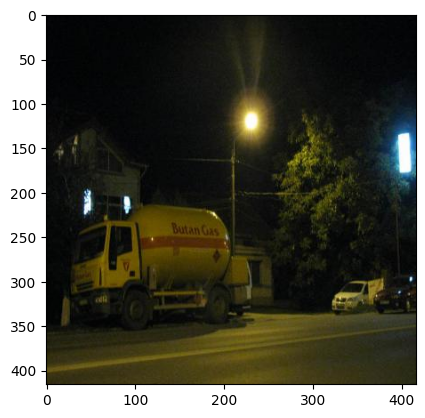

In [46]:
print(f"Class ID: {train_labels[0][0]}")
for box in train_labels: print(f"Box Coordinates: {box}")
img = train_features[0]
img = img.permute(1, 2, 0)
print(img.shape)
plt.imshow(img)
plt.show()

In [47]:
# unnormalize test images
def unnormlalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Convert tensor image to correct openCV image format
def tensor_to_cv2_image(tensor):
    # unnormalize
    tensor = unnormlalize(tensor, mean, std)
    
    # Convert GPU tensor to CPU based
    image = tensor.cpu().numpy() 
    image = (image * 255) # convert to unnormalized pixel values
    image = np.ascontiguousarray(image, np.uint8)
    return image

# Draw boxes on image
def draw_boxes(image, label):
    class_id, x_center, y_center, width, height = label
    
    # Get image dimensions
    image_height, image_width = image.shape[1], image.shape[0]
    
    # Convert normalized coordinates to pixel coordinates
    x_center = int(x_center * image_width)
    y_center = int(y_center * image_height)
    width = int(width * image_width)
    height = int(height * image_height)
    
    # Calculate bounding box corners
    x_min = int(x_center - width / 2)
    y_min = int(y_center - height / 2)
    x_max = int(x_center + width / 2)
    y_max = int(y_center + height / 2)
    
    # Place box coordinates       
    cv.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    cv.putText(image, str(int(class_id)), (x_min, y_min - 10), cv.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return image

In [48]:
# Convert image tensor to openCV image
image = tensor_to_cv2_image(img)
print("Image Type:", type(image))
print("Image Shape:", image.shape)

# Draw box on image
image = draw_boxes(image, train_labels[0])

Image Type: <class 'numpy.ndarray'>
Image Shape: (416, 416, 3)


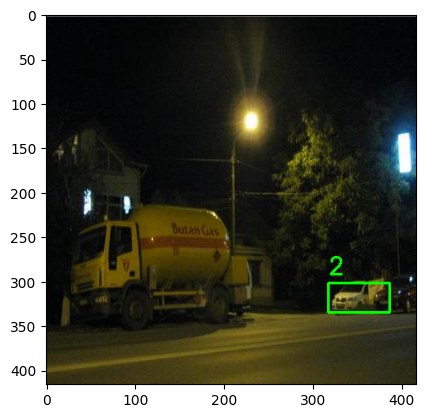

In [49]:
plt.imshow(image)

In [50]:
# NORMALIZE MY TESTING DATA????

# NEXT
    # Create model + loss function & optimizer
    # Train model
    # Test model
        # Test OpenCV live detection
        
        
# NEXT PROJECT IDEA
    # USE CUDA FOR PARALLEL COMPUTING SHIT

In [51]:
# Helper function
def conv_size(size, conv_kernel_size, pool_kernel_size, padding, conv_stride, pool_stride):
    output_size = ((size - conv_kernel_size + 2 * padding) / conv_stride) + 1
    output_size = ((output_size - pool_kernel_size) / pool_stride) + 1
    return output_size

size = conv_size(416, 3, 2, 0, 1, 2)
size = conv_size(size, 3, 2, 0, 1, 2)
size = conv_size(size, 3, 2, 0, 1, 2)
size

50.25

In [52]:
import torch.nn as nn
import torch.nn.functional as F

class DetectNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected Layers
        self.fc1 = nn.Linear(32 * 50 * 50, 120)
        self.fc2 = nn.Linear(120, 64)
        
        # Separate output heads for classification and bounding box regression
        self.fc_class = nn.Linear(64, 5) # 5 classes
        self.fc_bbox = nn.Linear(64, 4) # 4 coordinates for Bounding Box
        
        # Activation Function
        self.relu = nn.ReLU() # Output: (0,x)
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        
        # Flatten 3D tensor to 1D for FFNN
        x = torch.flatten(x, 1)
        
        # Feed forward pass
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        
        # Output heads
        class_output = self.fc_class(x)
        bbox_output = self.fc_bbox(x)
        
        return class_output, bbox_output

In [53]:
# Move model to GPU
net = DetectNet().to('cuda')

# 3. Define loss function and optimizer
import torch.optim as optim

criterion_class = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9)

In [54]:
# # 4. Train the network
# for epoch in range(10): # loop dataset multiple times
    
#     running_loss = 0.0
#     for i, data in enumerate(norm_trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         # ensure we have cuda data
#         inputs = inputs.to('cuda')
#         labels = torch.stack(labels).to('cuda')
        
#         # Labels: List of batch_size tensors with n classified
#         # Grab tensor within the labels list
#         class_labels = labels[:, 0].long() # CrossEntropy requires LongTensor
#         bbox_labels = labels[:, 1:]
        
#         # zero the parameter gradients
#         optimizer.zero_grad()
        
#         # forward pass
#         class_outputs, bbox_outputs = net(inputs)
        
#         # compute losses
#         loss_class = criterion_class(class_outputs, class_labels)
#         loss_bbox = criterion_bbox(bbox_outputs, bbox_labels)
#         loss = loss_class + loss_bbox
        
#         # backwards pass
#         loss.backward()
#         optimizer.step()
        
#     # print statistics
#     epoch_loss = running_loss / len(norm_trainloader)
#     print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}')
            
# print('Finished Training')

In [55]:
# load model
net.load_state_dict(torch.load('../models/detect_net.pth'))

<All keys matched successfully>

In [56]:
# 5. Test the network on test data
# correct = 0
# total = 0
# with torch.no_grad():
#     net.eval()  # Set model to evaluation mode
#     for data in testloader:
#         images, labels = data
#         images = images.to('cuda')
#         labels = [label.to('cuda') for label in labels]
#         labels = torch.stack(labels)
        
#         # Separate class labels and bbox labels if needed
#         class_labels = labels[:, 0].long()  # Assuming first label is class ID
#         bbox_labels = labels[:, 1:]  # Assuming remaining labels are bbox coordinates
        
#         # Forward pass
#         class_outputs, bbox_outputs = net(images)
        
#         # Example of calculating accuracy for classification
#         _, predicted = torch.max(class_outputs, 1)
#         total += class_labels.size(0)
#         correct += (predicted == class_labels).sum().item()
        
#     print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))


Accuracy of the network on the test images: 47 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3913404..2.0081189].


Class ID: 1.0
torch.Size([416, 416, 3])
tensor([[[0.7121, 0.7087, 0.6696],
         [0.7402, 0.7370, 0.6696],
         [0.8387, 0.8358, 0.7374],
         ...,
         [0.4306, 0.5534, 0.5611],
         [0.3743, 0.4827, 0.5611],
         [0.3180, 0.4262, 0.5069]],

        [[0.7543, 0.7511, 0.6560],
         [0.8528, 0.8641, 0.7238],
         [1.0639, 1.0759, 0.8865],
         ...,
         [0.2899, 0.4121, 0.4255],
         [0.2477, 0.3697, 0.4119],
         [0.2055, 0.3133, 0.3984]],

        [[0.7965, 0.7935, 0.5611],
         [0.7262, 0.7370, 0.4797],
         [0.7543, 0.7652, 0.4797],
         ...,
         [0.2758, 0.3980, 0.4119],
         [0.2477, 0.3697, 0.4119],
         [0.2336, 0.3415, 0.4255]],

        ...,

        [[0.3462, 0.6522, 0.6560],
         [0.3462, 0.6522, 0.6560],
         [0.3321, 0.6381, 0.6424],
         ...,
         [0.4166, 0.7087, 0.7374],
         [0.4166, 0.7087, 0.7374],
         [0.4166, 0.7087, 0.7374]],

        [[0.3462, 0.6522, 0.6560],
       

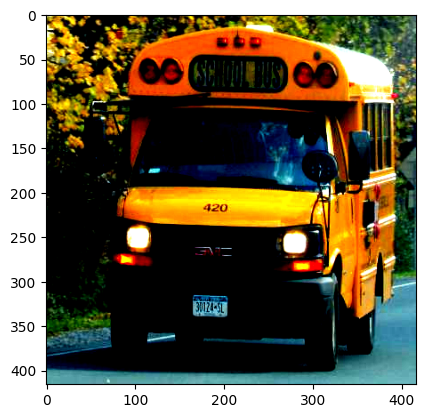

In [61]:
# Show image and prediction
dataiter = iter(testloader)
image_out, label_out = next(dataiter)

print(f"Class ID: {label_out[0][0]}")
img = image_out[0]
img = img.permute(1, 2, 0)
print(img.shape)
print(img)
plt.imshow(img)
plt.show()

In [58]:
image_out = image_out.to('cuda')

# Perform inference
with torch.no_grad():
    net.eval()  # Set model to evaluation mode
    class_pred, bbox_pred = net(image_out)

    print(class_pred)
    print(bbox_pred[0])

# Assuming outputs shape is [batch_size, num_classes]
_, predicted = torch.max(class_pred, 1)
x_center, y_center, width, height = bbox_pred[0].tolist()
bbox_out = [float(predicted[0]), x_center, y_center, width, height]

# Print predictions for each image in the batch
print('\nPredicted Class:', classes[predicted[0].item()])
print('Predicted Bounding Box:', bbox_out)

tensor([[-0.4686,  0.0018,  0.7833, -0.1667, -0.3149],
        [-1.0528,  0.2760,  0.6602, -0.5668,  0.0791],
        [-0.4770,  0.0101,  0.7832, -0.1890, -0.2947],
        [-0.5300,  0.0369,  0.7710, -0.2224, -0.2594],
        [-0.6252,  0.0823,  0.7418, -0.2691, -0.2076],
        [-0.4816,  0.0174,  0.7815, -0.1863, -0.2941],
        [-0.9533,  0.2382,  0.6828, -0.5060,  0.0115],
        [-0.5713,  0.0583,  0.7691, -0.2414, -0.2356]], device='cuda:0')
tensor([0.4596, 0.4901, 0.4610, 0.5566], device='cuda:0')

Predicted Class: Car
Predicted Bounding Box: [2.0, 0.4596259295940399, 0.4900828003883362, 0.4609794020652771, 0.556606113910675]


Image Type: <class 'numpy.ndarray'>
Image Shape: (416, 416, 3)
[[[166 165 162]
  [168 167 162]
  [175 174 167]
  ...
  [146 154 155]
  [142 149 155]
  [138 145 151]]

 [[166 166 159]
  [173 174 164]
  [188 189 175]
  ...
  [133 142 142]
  [130 139 141]
  [127 135 141]]

 [[167 167 150]
  [162 162 144]
  [164 165 144]
  ...
  [128 137 139]
  [126 135 139]
  [125 133 140]]

 ...

 [[ 88 166 167]
  [ 88 166 167]
  [ 84 162 163]
  ...
  [106 180 188]
  [106 180 188]
  [106 180 188]]

 [[ 88 166 167]
  [ 84 162 163]
  [ 84 162 163]
  ...
  [106 180 188]
  [106 180 188]
  [106 180 188]]

 [[ 84 162 163]
  [ 84 162 163]
  [ 84 162 163]
  ...
  [106 180 188]
  [106 180 188]
  [106 180 188]]]


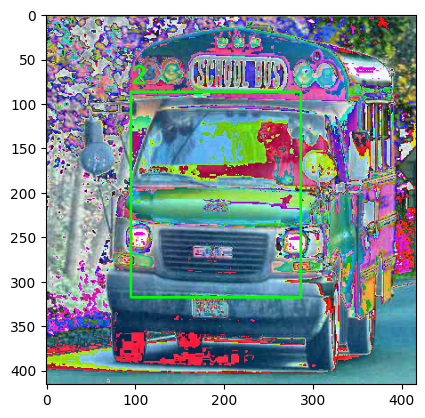

In [62]:
# Convert image tensor to openCV image
image = tensor_to_cv2_image(img)
print("Image Type:", type(image))
print("Image Shape:", image.shape)
print(image)
# Draw box on image
image = draw_boxes(image, bbox_out)

plt.imshow(image)

In [60]:
# # Save model
# PATH = '../models/detect_net.pth'
# torch.save(net.state_dict(), PATH)